# Using Pre-Trained Networks on Small Datasets

## Goal: Classify Types of X-Ray: Chest or Abdomen

In the previous example, we trained a network from scratch using 60,000 images. Having 60,000 images with classes predefined is convenient, but not necessarily always available for every application. Sometimes, only small datasets are available. For instance, in this example we only have 65 training images available, three orders of magnitude less than the MNIST example and an insufficient number to train a network from scratch.

<p float="left">
    <img src="Open_I_abd_vs_CXRs/TRAIN/openI_CXR/80_IM-2333-3001_invert.png" width="300" />
    <img src="Open_I_abd_vs_CXRs/TRAIN/openI_abd_xray/openI_6.png" width="300" />
</p>

In [1]:
import matplotlib.pyplot as plt

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
img_width, img_height = 299, 299               # dimensions of our input -- our model only accepts 299 x 299

# location of training and test datasets
train_data_dir = 'Open_I_abd_vs_CXRs/TRAIN'    #location of training data
validation_data_dir = 'Open_I_abd_vs_CXRs/VAL' #location of validation data

nb_train_samples = 65                          # number of samples used for determining the samples_per_epoch
nb_validation_samples = 10                     # number of samples used for validating (i.e., testing during training)
epochs = 15
batch_size = 5

In [3]:
# data augmentation to generate more variability and reduce overfitting

train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalizing
        shear_range=0.2,      
        zoom_range=0.2,    
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)  

# no need to augment validation except for normalization
val_datagen = ImageDataGenerator(
         rescale=1./255)       # normalize pixel values to [0,1]

In [4]:
# create data loaders for training and test sets

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [5]:
# Unlike previous exercises, we will not build and train a model from scratch
# There just simply isn't enough data!

# We could instead train on top of a pre-trained network and slightly tweak it to learn how to recognize our images.
# This is like teaching an expert piano player a new song.
# The work of past years of training has already been done.

# Let's use the InceptionV3 network that has been pretrained on millions of images.
# Instead of using it's top layer which is used for its final classification of several other classes
# we'll instead remove it and add a shallow network on top to predict only two final classes.

base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [6]:
# The new top of our InceptionV3 pre-trained model.

model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None)),  
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid')) 

In [7]:
# We now put the new top onto the network

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

# Our optimizer uses Adam once more, but our loss function is calculated using binary cross-entropy 
# because we only have two outputs to consider

# Note the small initial learning rate
# This is on purpose because we don't want to disturb the weights of the network too much
# Remember, our musician is learning a new song -- not a whole other instrument!

model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Run the model

history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
13/13 [==============================] - 16s 1s/step - loss: 0.5288 - acc: 0.7538 - val_loss: 0.1830 - val_acc: 1.0000
Epoch 2/20
13/13 [==============================] - 2s 182ms/step - loss: 0.1902 - acc: 0.9385 - val_loss: 0.0370 - val_acc: 1.0000
Epoch 3/20
13/13 [==============================] - 2s 187ms/step - loss: 0.1515 - acc: 0.9385 - val_loss: 0.0128 - val_acc: 1.0000
Epoch 4/20
13/13 [==============================] - 2s 183ms/step - loss: 0.3452 - acc: 0.8769 - val_loss: 0.0143 - val_acc: 1.0000
Epoch 5/20
13/13 [==============================] - 2s 184ms/step - loss: 0.1887 - acc: 0.9231 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 6/20
13/13 [==============================] - 2s 183ms/step - loss: 0.0565 - acc: 0.9846 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 7/20
13/13 [==============================] - 2s 184ms/step - loss: 0.2729 - acc: 0.8923 - val_loss: 0.0102 - val_acc: 1.0000
Epoch 8/20
13/13 [==============================] - 2s 183ms/step - loss: 0.01

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


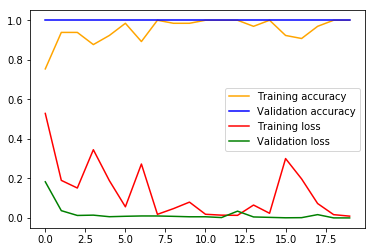

In [9]:
# Plot the training stats

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()


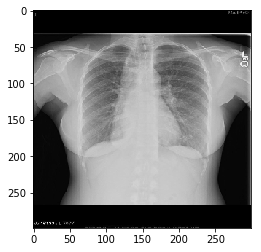

Predicted: [[0.00016193]] Chest X-ray


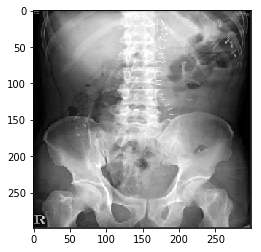

Predicted: [[0.99997056]] Abd X-ray


In [10]:
import numpy as np
from keras.preprocessing import image

img_path= 'Open_I_abd_vs_CXRs/TEST/chest2.png' #change to location of chest x-ray
img_path2= 'Open_I_abd_vs_CXRs/TEST/abd2.png'  #change to location of abd x-ray
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))
plt.imshow(img)
plt.show()

img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255
score = model.predict(x)
print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')

plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')
